# ***Important Libraries and data***

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Add, Input, Activation, ZeroPadding2D, BatchNormalization, Flatten, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model, to_categorical

In [2]:
import matplotlib.pyplot as plt

In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
FILE_PATH = "/content/drive/MyDrive/Datasets/PlantVillage/"

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = FILE_PATH,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 8837 files belonging to 9 classes.


In [7]:
class_names = dataset.class_names

In [8]:
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus']

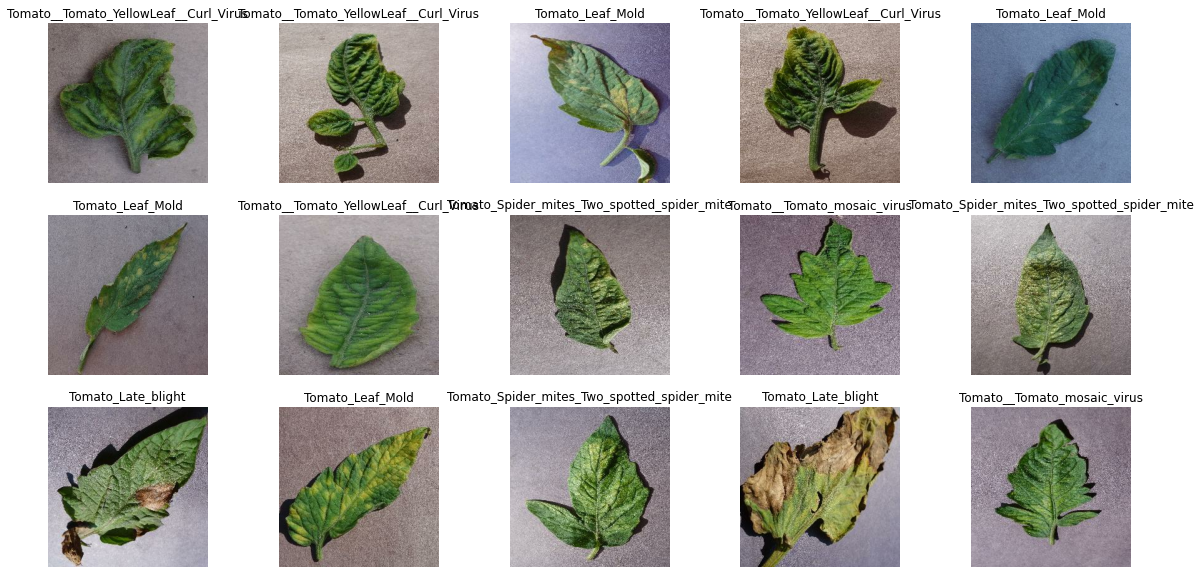

In [9]:
plt.figure(figsize = (20,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(15):
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [10]:
def dataset_split(dataset, train_split = 0.7, test_split = 0.2, val_split = 0.1, shuffle = True, shuffle_size = 10000):
  # assert  train_split+test_split+val_split == 1
  dataset_size = len(dataset)
  if shuffle:
    dataset.shuffle(shuffle_size, seed = 10)
  
  train_size = int(len(dataset) * train_split)
  test_size = int(len(dataset) * test_split)
  
  train_data = dataset.take(train_size)
  test_data = dataset.skip(train_size).take(test_size)
  val_data = dataset.skip(train_size).skip(test_size)

  return train_data, test_data, val_data

In [11]:
train_data, test_data, val_data = dataset_split(dataset)

In [12]:
print(f"Size of train data: {len(train_data)} \nSize of test data: {len(test_data)} \nSize of validation data: {len(val_data)}")

Size of train data: 193 
Size of test data: 55 
Size of validation data: 29


In [13]:
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# ***Resnet Architecture Development***

# ***Identity And Convolutional Block***
<img src = "https://cdn-images-1.medium.com/max/1600/1*SGrc3VC3fbirosDPW0AmMA.png" height = 350px>

In [14]:
def identity_block(x, f :int, filters :list):

  # Get number of filters
  f1, f2, f3 = filters

  x_map = x

  # First Layer
  x = Conv2D(filters = f1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Second Layer
  x = Conv2D(filters = f2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Third Layer
  x = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Finally map input to output
  x = Add()([x, x_map])
  x = Activation('relu')(x)

  return x

In [15]:
def conv_block(x, f :int, filters :list, stride = 2):
  
  # Get filters
  f1, f2, f3 = filters

  x_map = x

  # First Layer
  x = Conv2D(filters = f1, kernel_size = (1, 1), strides = (stride, stride), padding = 'valid')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Second Layer
  x = Conv2D(filters = f2, kernel_size = (f, f), strides = (1, 1), padding = 'same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # Third Layer
  x = Conv2D(filters = f3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid')(x)
  x = BatchNormalization()(x)

  # Mapping Layer
  x_map = Conv2D(f3, kernel_size = (1, 1), strides = (stride, stride), padding = 'valid')(x_map)
  x_map = BatchNormalization()(x_map)

  # Finally mapping x_map and output
  x = Add()([x, x_map])
  x = Activation('relu')(x)
  
  return x

# ***ResNet-50***
<img src = 'https://www.researchgate.net/publication/331364877/figure/download/fig3/AS:741856270901252@1553883726825/Left-ResNet50-architecture-Blocks-with-dotted-line-represents-modules-that-might-be.png'>

In [16]:
def ResNet50(input_shape = (256, 256, 3), classes = 10):
  
  # Defining input with input shape of dataset
  x_input = Input(input_shape)

  # Zero-Padding
  x = ZeroPadding2D((3, 3))(x_input)

  # Stage 1
  x = Conv2D(64, (7, 7), strides = (2, 2))(x)
  x = BatchNormalization(axis = 3)(x)
  x = Activation('relu')(x)
  x = MaxPooling2D((3, 3), strides = (2, 2))(x)

  # Stage 2
  x = conv_block(x, f = 3, filters = [64, 64, 256], stride = 1)
  x = identity_block(x, f = 3, filters = [64, 64, 256])
  x = identity_block(x, f = 3, filters = [64, 64, 256])

  # Stage 3
  x = conv_block(x, f = 3, filters = [128, 128, 512], stride = 2)
  x = identity_block(x, f = 3, filters = [128, 128, 512])
  x = identity_block(x, f = 3, filters = [128, 128, 512])
  x = identity_block(x, f = 3, filters = [128, 128, 512])

  # Stage 4
  x = conv_block(x, f = 3, filters = [256, 256, 1024], stride = 2)
  x = identity_block(x, f = 3, filters = [256, 256, 1024])
  x = identity_block(x, f = 3, filters = [256, 256, 1024])
  x = identity_block(x, f = 3, filters = [256, 256, 1024])
  x = identity_block(x, f = 3, filters = [256, 256, 1024])
  x = identity_block(x, f = 3, filters = [256, 256, 1024])

  # Stage 5
  x = conv_block(x, f = 3, filters = [512, 512, 2048], stride = 2)
  x = identity_block(x, f = 3, filters = [512, 512, 2048])
  x = identity_block(x, f = 3, filters = [512, 512, 2048])

  # AVGPOOL
  x = AveragePooling2D((2, 2), name = 'Avg_Pool')(x)

  # Output Layer
  x = Flatten()(x)
  x = Dense(classes, activation = 'softmax', kernel_initializer = keras.initializers.glorot_uniform(seed = 0))(x)

  # Model
  model = Model(inputs = x_input, outputs = x, name = 'Resnet-50')

  return model

In [17]:
model = ResNet50()

In [18]:
model.compile(optimizer = 'adam', loss = keras.losses.SparseCategoricalCrossentropy, metrics = ['accuracy'])

In [19]:
model.summary()

Model: "Resnet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                          